In [99]:
import pandas as pd
import numpy as np
import pickle as pkl
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [53]:
import collections, re

In [3]:
data = pd.read_csv("../data/all_cohort_notes_Oct17.csv")
print(data.shape)
#data.head()

(152753, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICUSTAY_ID,FIRST_VENT_STARTTIME,TIME_DIFF,TIME_FROM_VENT
0,316480,31916,146431.0,2112-02-23,2112-02-23 03:51:00,2112-02-23 04:03:01,Nursing,Nursing Progress Note,14419.0,NaN,"Respiratory failure, acute (not ARDS/[**Doctor...",255563.0,2112-02-22 04:05:00,23.0,23.766667
1,317750,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:22:26,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
2,317751,27866,109679.0,2143-04-09,2143-04-09 03:22:00,2143-04-09 03:27:59,Nursing,Nursing Progress Note,21297.0,NaN,Ms. [**Known lastname 1170**] is an 83 yo F w/...,272695.0,2143-04-09 00:00:00,3.0,3.366667
3,318002,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:30,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000
4,318003,29487,116532.0,2163-01-20,2163-01-20 05:12:00,2163-01-20 05:12:52,Nursing,Nursing Progress Note,21336.0,NaN,No significant events overnight\n Renal fail...,245788.0,2163-01-18 15:00:00,38.0,38.200000


In [4]:
#merge notes of same HADM_ID
#merged_data = data.dropna()[['SUBJECT_ID', "HADM_ID"]].drop_duplicates()
#merged_data["ALLTEXT"] = merged_data.HADM_ID.apply(lambda hadm_id: "\n".join(data[data.HADM_ID == hadm_id].TEXT))

In [275]:
#merged_data.head()

In [276]:
#merged_data.shape

In [13]:
len(np.unique(data[['SUBJECT_ID','HADM_ID']].values))

33054

In [24]:
data_new = data.drop_duplicates(subset=['HADM_ID','SUBJECT_ID'])
data_new["ALLTEXT"] = data_new.HADM_ID.apply(lambda hadm_id: "\n".join(data[data.HADM_ID == hadm_id].TEXT))

/home/mcb/li_lab/pnair6/venv/mcb36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
data_new.shape

(17400, 16)

In [277]:
#data_new.head()

In [27]:
data_new = data_new[['SUBJECT_ID','HADM_ID','ALLTEXT']]

In [31]:
def process(text):
    # convert to lower case
    lower = text.lower()
    # remove punc
    no_punc = lower.translate(str.maketrans("", "", string.punctuation))
    # remove white space
    no_white = " ".join(no_punc.split())
    # remove numbers
    no_num = no_white.translate(str.maketrans("", "", string.digits))
    # remove stopwords
    sw = set(stopwords.words('english'))
    no_sw = " ".join([word for word in no_num.split() if word not in sw])
    return no_sw

In [32]:
# preprocess notes
data_new["PRO_TEXT"] = data_new.ALLTEXT.apply(lambda text: process(text))

In [278]:
#data_new.head()

In [42]:
len(data_new.HADM_ID.unique())

17400

In [43]:
data_small = data_new[["HADM_ID","PRO_TEXT"]]

In [47]:
vectorizer = CountVectorizer(min_df=5)
_ = vectorizer.fit_transform(data_small['PRO_TEXT'])
word_index = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}

In [225]:
word_counts = np.zeros(len(word_index),dtype=int)

In [279]:
# Number of words in the corpus
len(word_index)

30763

In [85]:
bagsofwords = [collections.Counter(re.findall(r'\w+', txt))
            for txt in data_small.PRO_TEXT]

In [229]:
ind = 0
for counter in bagsofwords:
    words = counter.keys()
    for w in words:
        if w in word_index:
            word_counts[word_index[w]] += 1

In [208]:
word_ids = word_index.values()

In [231]:
patient_fractions = [i/17400 for i in word_counts]

In [232]:
pat_fr = sorted(patient_fractions)

In [213]:
def get_index(ind):
    return patient_fractions[ind]

In [235]:
sorted_word_ids = sorted(word_ids,key= get_index)

In [237]:
new_axis = [x for _,x in sorted(zip(pat_fr,word_ids))]

In [240]:
m = np.diff(pat_fr)/np.diff(new_axis)

In [242]:
idx = np.nonzero(np.diff(m))[0]

In [281]:
# arbitrarily chosen to exclude words occuring in more than 10% of the documents
limit = idx[2100]
pat_fr[limit]

0.10551724137931034

Text(0.5, 0, 'Word ID')

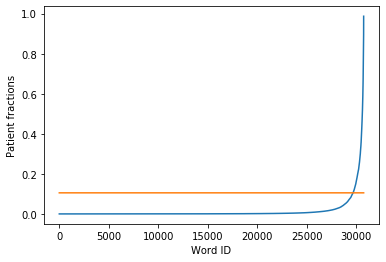

In [285]:
plt.plot(new_axis, pat_fr,[pat_fr[limit]]*len(new_axis))
plt.ylabel("Patient fractions")
plt.xlabel("Word ID")

In [266]:
sw_new = sorted_word_ids[limit:]

In [183]:
# inverting the word:id dictionary
inv_word_ind = {v: k for k, v in word_index.items()}

In [268]:
modified_sw = []
for sw_ind in sw_new:
    modified_sw.append(inv_word_ind[sw_ind])

In [269]:
# number of new stopwords added
len(modified_sw)

1074

In [274]:
# saving the new stopwords as a pickle file
#with open('more_stopwords.pickle', 'wb') as handle:
#    pkl.dump(modified_sw, handle, protocol=pkl.HIGHEST_PROTOCOL)